In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
import pickle

In [2]:
#load data
train_df = pd.read_csv("../data/processed/train_tickets.csv")
val_df = pd.read_csv("../data/processed/val_tickets.csv")
test_df = pd.read_csv("../data/processed/test_tickets.csv")

# custom stopwords from EDA insights
custom_stopwords = [
    'analytics', 'assistance', 'brand', 'breach', 'data', 'digital', 'inquiry',
    'integration', 'investment', 'issue', 'issues', 'management', 'marketing',
    'medical', 'performance', 'problem', 'project', 'request', 'saas', 'security',
    'software', 'strategies', 'support', 'tools'
]

all_stopwords = list(ENGLISH_STOP_WORDS.union(custom_stopwords))

#initialize TfidfVectorizer
tfidf = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2),
    stop_words=all_stopwords
)

# fit the vectorizer
X_train = tfidf.fit_transform(train_df["redacted_text"])
X_val = tfidf.transform(val_df["redacted_text"])
X_test = tfidf.transform(test_df["redacted_text"])

# encode labels
le = LabelEncoder()
y_train = le.fit_transform(train_df["queue_grouped"])
y_val = le.transform(val_df["queue_grouped"])
y_test = le.transform(test_df["queue_grouped"])

# initialize and fit logistic regression
clf = LogisticRegression(
    class_weight="balanced", 
    random_state=42
)
clf.fit(X_train, y_train)

# predict on validation and test sets
y_val_pred = clf.predict(X_val)
y_test_pred = clf.predict(X_test)

print(
    "Validation Classification Report:\n",
    classification_report(y_val, y_val_pred, target_names=le.classes_),
)
print(
    "Test Classification Report:\n",
    classification_report(y_test, y_test_pred, target_names=le.classes_),
)

Validation Classification Report:
                                        precision    recall  f1-score   support

                 Billing and Payments       0.77      0.76      0.76       288
Customer Service, Returns & Exchanges       0.47      0.46      0.47       582
                      General Inquiry       0.31      0.54      0.39        41
                      Human Resources       0.32      0.65      0.43        60
                      Product Support       0.46      0.50      0.48       547
                  Sales and Pre-Sales       0.33      0.69      0.44        90
      Service Outages and Maintenance       0.49      0.76      0.60       120
               Technical & IT Support       0.71      0.54      0.61      1222

                             accuracy                           0.55      2950
                            macro avg       0.48      0.61      0.52      2950
                         weighted avg       0.59      0.55      0.56      2950

Test Classific

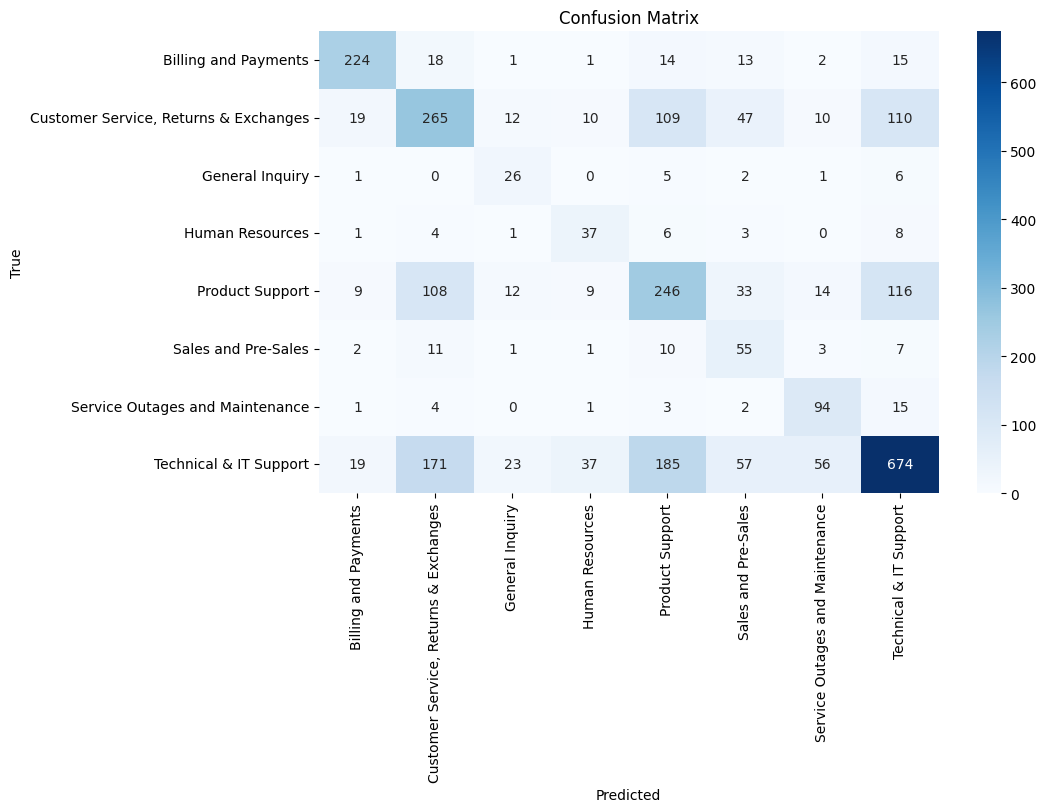

In [3]:
#confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 6))

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=le.classes_,
    yticklabels=le.classes_,
    cmap="Blues",
)

plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

As expected the model doesn't perform well prior to tuning, let's tune the model and re-assess.

In [4]:
#parameter tuning with RandomizedSearchCV
param_dist = {
    "C": [0.001, 0.01, 0.1, 0.5, 1, 2, 5, 10],
    "penalty": ["l2"],
    "solver": ["lbfgs", "saga"],
    "class_weight": ["balanced"],
    "max_iter": [10000, 20000, 30000],
    "fit_intercept": [True, False],
}

RandomizedSearchCV
rs = RandomizedSearchCV(
    clf,
    param_distributions=param_dist,
    n_iter=20,
    cv=3,
    scoring="f1_weighted",
    verbose=2,
    random_state=42
)

subset_idx = np.random.choice(X_train.shape[0], size=min(6500, X_train.shape[0]), replace=False)
X_subset = X_train[subset_idx]
y_subset = y_train[subset_idx]

rs.fit(X_subset, y_subset)

print("Best parameters found:", rs.best_params_)
print("Best weighted F1 score:", rs.best_score_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END C=5, class_weight=balanced, fit_intercept=False, max_iter=20000, penalty=l2, solver=lbfgs; total time=   0.1s
[CV] END C=5, class_weight=balanced, fit_intercept=False, max_iter=20000, penalty=l2, solver=lbfgs; total time=   0.1s
[CV] END C=5, class_weight=balanced, fit_intercept=False, max_iter=20000, penalty=l2, solver=lbfgs; total time=   0.2s


c:\Users\toobr\anaconda3\envs\siads699\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=5, class_weight=balanced, fit_intercept=True, max_iter=30000, penalty=l2, solver=saga; total time= 4.7min


c:\Users\toobr\anaconda3\envs\siads699\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=5, class_weight=balanced, fit_intercept=True, max_iter=30000, penalty=l2, solver=saga; total time= 5.3min


c:\Users\toobr\anaconda3\envs\siads699\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=5, class_weight=balanced, fit_intercept=True, max_iter=30000, penalty=l2, solver=saga; total time= 4.4min


c:\Users\toobr\anaconda3\envs\siads699\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=5, class_weight=balanced, fit_intercept=True, max_iter=10000, penalty=l2, solver=saga; total time= 1.3min


c:\Users\toobr\anaconda3\envs\siads699\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=5, class_weight=balanced, fit_intercept=True, max_iter=10000, penalty=l2, solver=saga; total time= 1.3min


c:\Users\toobr\anaconda3\envs\siads699\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=5, class_weight=balanced, fit_intercept=True, max_iter=10000, penalty=l2, solver=saga; total time= 1.5min
[CV] END C=10, class_weight=balanced, fit_intercept=False, max_iter=30000, penalty=l2, solver=lbfgs; total time=   0.2s
[CV] END C=10, class_weight=balanced, fit_intercept=False, max_iter=30000, penalty=l2, solver=lbfgs; total time=   0.1s
[CV] END C=10, class_weight=balanced, fit_intercept=False, max_iter=30000, penalty=l2, solver=lbfgs; total time=   0.2s
[CV] END C=0.1, class_weight=balanced, fit_intercept=False, max_iter=20000, penalty=l2, solver=saga; total time=   0.3s
[CV] END C=0.1, class_weight=balanced, fit_intercept=False, max_iter=20000, penalty=l2, solver=saga; total time=   0.2s
[CV] END C=0.1, class_weight=balanced, fit_intercept=False, max_iter=20000, penalty=l2, solver=saga; total time=   0.2s


c:\Users\toobr\anaconda3\envs\siads699\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=5, class_weight=balanced, fit_intercept=False, max_iter=10000, penalty=l2, solver=saga; total time= 1.2min


c:\Users\toobr\anaconda3\envs\siads699\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=5, class_weight=balanced, fit_intercept=False, max_iter=10000, penalty=l2, solver=saga; total time= 1.4min


c:\Users\toobr\anaconda3\envs\siads699\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=5, class_weight=balanced, fit_intercept=False, max_iter=10000, penalty=l2, solver=saga; total time= 1.1min


c:\Users\toobr\anaconda3\envs\siads699\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=2, class_weight=balanced, fit_intercept=False, max_iter=20000, penalty=l2, solver=saga; total time= 2.5min


c:\Users\toobr\anaconda3\envs\siads699\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=2, class_weight=balanced, fit_intercept=False, max_iter=20000, penalty=l2, solver=saga; total time= 2.3min


c:\Users\toobr\anaconda3\envs\siads699\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=2, class_weight=balanced, fit_intercept=False, max_iter=20000, penalty=l2, solver=saga; total time= 2.3min
[CV] END C=0.5, class_weight=balanced, fit_intercept=False, max_iter=10000, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.5, class_weight=balanced, fit_intercept=False, max_iter=10000, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.5, class_weight=balanced, fit_intercept=False, max_iter=10000, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.001, class_weight=balanced, fit_intercept=True, max_iter=10000, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.001, class_weight=balanced, fit_intercept=True, max_iter=10000, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.001, class_weight=balanced, fit_intercept=True, max_iter=10000, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.001, class_weight=balanced, fit_intercept=False, max_iter=30000, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.001, class_weight

c:\Users\toobr\anaconda3\envs\siads699\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1, class_weight=balanced, fit_intercept=True, max_iter=30000, penalty=l2, solver=saga; total time=12.4min


c:\Users\toobr\anaconda3\envs\siads699\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1, class_weight=balanced, fit_intercept=True, max_iter=30000, penalty=l2, solver=saga; total time= 8.2min


c:\Users\toobr\anaconda3\envs\siads699\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1, class_weight=balanced, fit_intercept=True, max_iter=30000, penalty=l2, solver=saga; total time= 3.9min


c:\Users\toobr\anaconda3\envs\siads699\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=10, class_weight=balanced, fit_intercept=True, max_iter=10000, penalty=l2, solver=saga; total time= 1.1min


c:\Users\toobr\anaconda3\envs\siads699\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=10, class_weight=balanced, fit_intercept=True, max_iter=10000, penalty=l2, solver=saga; total time= 1.2min


c:\Users\toobr\anaconda3\envs\siads699\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=10, class_weight=balanced, fit_intercept=True, max_iter=10000, penalty=l2, solver=saga; total time= 1.2min
Best parameters found: {'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': 30000, 'fit_intercept': False, 'class_weight': 'balanced', 'C': 10}
Best weighted F1 score: 0.5433986771588984


In [5]:
#initialize the best model
best_model = rs.best_estimator_

#fit on the full training set
best_model.fit(X_train, y_train)

#predict on validation and test sets
y_val_pred = best_model.predict(X_val)
y_test_pred = best_model.predict(X_test)

print(
    "Validation Classification Report:\n",
    classification_report(y_val, y_val_pred, target_names=le.classes_),
)
print(
    "Test Classification Report:\n",
    classification_report(y_test, y_test_pred, target_names=le.classes_),
)

Validation Classification Report:
                                        precision    recall  f1-score   support

                 Billing and Payments       0.81      0.81      0.81       288
Customer Service, Returns & Exchanges       0.52      0.57      0.54       582
                      General Inquiry       0.57      0.41      0.48        41
                      Human Resources       0.57      0.65      0.61        60
                      Product Support       0.47      0.55      0.51       547
                  Sales and Pre-Sales       0.54      0.61      0.57        90
      Service Outages and Maintenance       0.66      0.78      0.72       120
               Technical & IT Support       0.72      0.63      0.67      1222

                             accuracy                           0.62      2950
                            macro avg       0.61      0.63      0.61      2950
                         weighted avg       0.63      0.62      0.62      2950

Test Classific

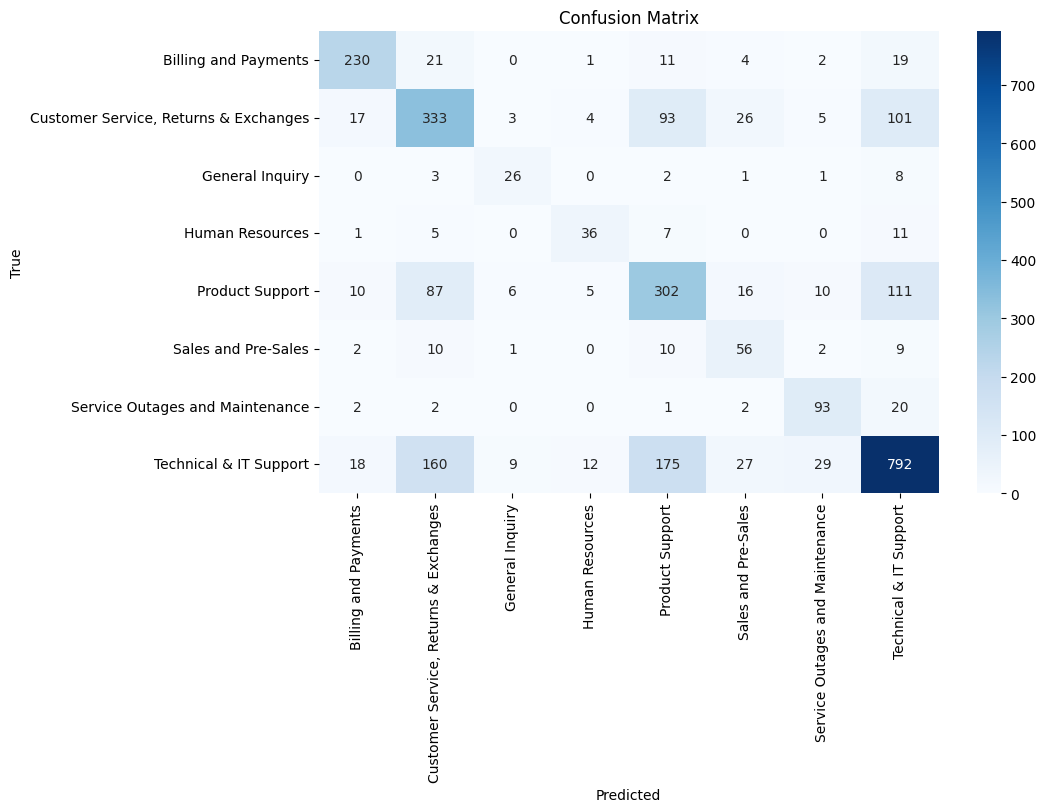

In [6]:
#confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 6))

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=le.classes_,
    yticklabels=le.classes_,
    cmap="Blues",
)

plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

The model shows some improvement, but it still requires further work, with a F1 score of only 0.64 on the test set. This model struggles with sales, product support, and customer service queues.

In [9]:
#save the model and vectorizer
with open("../models/logreg_tfidf_tuned.pkl", "wb") as f:
    pickle.dump((tfidf, rs.best_estimator_), f)